# Adding custom PDFs
The "minkit" package allows to easily register new PDFs.
Depending on the backend to be used, the PDF code must be implemented in C++ or in both C++ and CUDA.
The latter is needed since the single-value evaluation function and the normalization are taken from the C++ source file of the PDFs. In the following lines, it will be shown how to register a new PDF in both CPU and GPU backends.

## Adding a custom PDF in the CPU backend
In order to add a new PDF for CPU, we must create a source C++ file, and tell the "minkit" package to add its directory to the list of directories to search for PDFs. For this example, we will create a C++ file from python on a temporary directory.

In [1]:
import minkit
import os
import tempfile

minkit.initialize(backend='cpu')

tmpdir = tempfile.TemporaryDirectory()

with open(os.path.join(tmpdir.name, 'CustomPDF.cpp'), 'wt') as f:
    f.write('''
        #include <cmath>

        extern "C" {

          static inline double shared_function( double x, double k ) {
            return std::exp(k * x);
          }
          
          static inline double integral( double k, double xmin, double xmax ) {
            return 1. / k * (std::exp(k * xmax) - std::exp(k * xmin));
          }

          double function( double x, double k ) {
            return shared_function(x, k);
          }

          void evaluate( int len, double *out, double* in, double k ) {
            for ( int i = 0; i < len; ++i )
              out[i] = shared_function(in[i], k);
          }

          void evaluate_binned( int len, double *out, double k, double *edges ) {
            for ( int i = 0; i < len; ++i )
              out[i] = integral(k, edges[i], edges[i + 1]);
          }

          double normalization( double k, double xmin, double xmax ) {
            return integral(k, xmin, xmax);
          }
    
        }
        ''')

Note that we have created four functions, although only two of them are usually needed:

* "shared_function" is an static function that will contain the actual function to evaluate (an exponential in this case).
* "function": is a version of the function to evaluate on a single value.
* "evaluate": is the function to be used on arrays, so the first element must be the length of the input arrays. The next argument corresponds to the pointer to the output array, followed by those of the input (data) arrays, and finally the arguments for the PDF.
* "evaluate_binned": function to be used when dealing with binned data sets. It must correspond to the integral of the PDF between two bounds, defined by "edges". If "normalization" is defined, one can also define "evaluate_binned". If it is not provided, MinKit will calculate it numerically.
* "normalization": this defines the way to integrate the PDF. If it is not provided, a numerical integration will be used.

In conclusion, only "function" and "evaluate" are actually needed, but one should always try to define "normalization" and "evaluate_binned", since calculating integrals numerically is very resource-consuming.

Now we have to register the PDF. In order to be used in python, we must tell minkit to look for PDFs in the temporary directory.

In [2]:
minkit.add_pdf_src(tmpdir.name)

Now we have to build a python object to represent the PDF. This is directly done when inheriting from "minkit.SourcePDF", which will automatically set our PDF.

In [3]:
@minkit.register_pdf
class CustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, k ):
        super(CustomPDF, self).__init__(name, [x], [k])

The "register_pdf" decorator is necessary if we want to save/load the PDF to/from JSON files. It is completely necessary that we call the function the same way we call the source file. The arguments to the "minkit.SourcePDF" constructor are the name of the PDF, the data parameters and the argument parameters. Now we can declare and use our function.

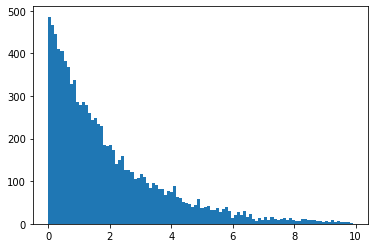

In [4]:
x = minkit.Parameter('x', bounds=(0, 10))
k = minkit.Parameter('k', -0.5)
pdf = CustomPDF('pdf', x, k)
data = pdf.generate(10000)
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(minkit.as_ndarray(data['x']), bins=100);

## New PDFs with a variable number of arguments
It might happen that one wants to define a general function, which depends on a list of parameters that can vary (for example, a polynomial) from one construction to another.
This can be done on a similar way to that of the previous section, providing as a third argument to "minkit.SourcePDF" the list of extra arguments.

In [5]:
@minkit.register_pdf
class VarArgsCustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, *coeffs ):
        super(VarArgsCustomPDF, self).__init__(name, [x], None, coeffs)

Note that one can also define PDFs with a set of fixed parameters and a set of variable parameters.

## Adding a custom PDF in the GPU backend
In order to add PDFs for GPU backends, one needs to define first the C++ version of it, presented in the previous sections. The source file for the GPU backend can be in any registered source path via the "minkit.add_pdf_src" function. The "minkit" package relies on "reikna" in order to define functions to run on GPUs, so the syntax must be the same as for any "reikna" function. Let's define the GPU version of the exponential.

In [6]:
with open(os.path.join(tmpdir.name, 'CustomPDF.c'), 'wt') as f:
    f.write('''
        KERNEL void evaluate( GLOBAL_MEM double *out, GLOBAL_MEM double *in, double k )
        {
            SIZE_T idx  = get_global_id(0);
            double x = in[idx];
            out[idx] = exp(k * x);
        }
        KERNEL void evaluate_binned( GLOBAL_MEM double *out, double k, double *edges )
        {
            SIZE_T idx = get_global_id(0);
            out[idx] = 1. / k * (exp(k * edges[idx + 1]) - exp(k * edges[idx]));
        }
        ''')

Not thate the arguments are the same as for the C++ version, but we have only defined the "evaluate" function here. For the GPU implementation we do not need to define the length of the element, since this is taken from the global ID of the running thread. To run on GPU we simply need to include these lines together before the construction of any CustomPDF class with the backend set to any GPU type, and we are ready to go.
